In [8]:
# %load full_load.py
#!/usr/bin/env python3

# Imports
import csv
import math
import os, os.path
import io
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from IPython.display import display

%matplotlib inline
sb.set()

def goldilocks_temp(t):
    if t < 273:
        return -1;
    elif t > 373:
        return 1;
    else:
        return 0

csv_filename = "./Data/exoplanetarchive/candidates-20190613-TIDIED.csv"
longnames = {}
with open(csv_filename, 'r') as f:
    lines = f.readlines()
    for line in lines[8:23]:
        varname, longname = line.strip().split(':')
        varname = varname[9:].strip()
        longname = longname.replace(',', '').strip()
        #print(varname, longname)
        longnames[varname] = longname
        
dataset = pd.read_csv(csv_filename, header = 24)

goldilocks_dataset = dataset.drop(['kepid',
                                   'koi_period',
                                   'koi_period_err1',
                                   'koi_prad_err1',
                                   #'koi_insol',
                                   'koi_insol_err1', 
                                   'koi_steff',
                                   'koi_steff_err1',
                                   'koi_slogg',
                                   'koi_slogg_err1',
                                   #'koi_srad',
                                   'koi_srad_err1'],
                                  axis=1).copy()
goldilocks_dataset.head()

goldilocks_dataset["gold_temp"] = list(map(goldilocks_temp, goldilocks_dataset["koi_teq"]))
goldilocks_dataset = goldilocks_dataset.dropna()

goldX = goldilocks_dataset.drop(["kepoi_name","koi_teq","gold_temp"], axis=1)
goldY = goldilocks_dataset['gold_temp']

goldX.columns = [longnames[x] for x in goldX.columns]

# Make the Datasets

just_right = goldilocks_dataset[goldilocks_dataset["gold_temp"] == 0].drop("kepoi_name",axis=1).copy()
too_hot = goldilocks_dataset[goldilocks_dataset["gold_temp"] == 1].drop("kepoi_name",axis=1).copy()
too_cold = goldilocks_dataset[goldilocks_dataset["gold_temp"] == -1].drop("kepoi_name",axis=1).copy()

# Split into X and Y

jrX = just_right.drop(["koi_teq", "gold_temp"], axis=1).copy()
jrY = just_right["gold_temp"]

thX = too_hot.drop(["koi_teq", "gold_temp"], axis=1).copy()
thY = too_hot["gold_temp"]

tcX = too_cold.drop(["koi_teq", "gold_temp"], axis=1).copy()
tcY = too_cold["gold_temp"]

from sklearn.model_selection import train_test_split

# Splitting the hot/cold/right arrays into test and train data
hotX_train, hotX_test, hotY_train, hotY_test = train_test_split(thX, thY, random_state=1)
coldX_train, coldX_test, coldY_train, coldY_test = train_test_split(tcX, tcY, random_state=1)
rightX_train, rightX_test, rightY_train, rightY_test = train_test_split(jrX, jrY, random_state=1)

# Concatenating and reordering the testing and training data

# Testing
testingX = pd.concat([hotX_test, coldX_test, rightX_test])
testingY = pd.concat([hotY_test, coldY_test, rightY_test])
testingX = testingX.reindex(testingX.index.sort_values())
testingY = testingY.reindex(testingY.index.sort_values())

# Training
trainingX = pd.concat([hotX_train, coldX_train, rightX_train])
trainingY = pd.concat([hotY_train, coldY_train, rightY_train])
trainingX = trainingX.reindex(trainingX.index.sort_values())
trainingY = trainingY.reindex(trainingY.index.sort_values())


Working through the SVM section in chapter 5, this is the only import that is used that I haven't yet already loaded:

In [10]:
from scipy import stats

Now, onto creating an instance of an SVM and running my data through it!

In [34]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)
model.fit(trainingX, trainingY)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

They make this function to easily plot margins; so I'll do the same!

In [77]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x, sparse=True)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Time to reload my own custom colormapping stuff!

In [79]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
gold_colours = ((0,0,1),(0,1,0),(1,0,0))
gold_colours = ListedColormap(gold_colours)

dim1 = "koi_prad"
dim2 = "koi_srad"
dim3 = "koi_insol"

dimmap = {dim1: (0,10),
          dim2: (0,2),
          dim3: (0,20)
         }

Xnew = testingX
ynew = model.predict(testingX)

def makeNewGraph(d1, d2, earth=False):
    # Define the figure size
    plt.figure(figsize=(10,8))
    
    #Plot the Training Data
    plt.scatter(trainingX[d1], trainingX[d2], c=trainingY.values, s=10, cmap=gold_colours, alpha=0.3)
    
    # Plot the Testing Data
    plt.scatter(Xnew[d1], Xnew[d2], c=ynew, s=10, cmap=gold_colours, alpha=0.7)
    
    # Plot EARTH
    if earth==True:
        plt.plot([1.0],[1.0],"o",color='#00ff00', markeredgewidth=1.5, markersize=6, linewidth='10', markeredgecolor='black')
    
    # Set Colourbar properties
    cbar = plt.colorbar()
    cbar.set_ticks([-1,0,1])
    cbar.set_ticklabels(['Too Cold','Just Right','Too Hot'])
    #cbar
    
    # Plot the labels
    plt.xlabel(longnames[d1])
    plt.ylabel(longnames[d2])
    
    plt.xlim(dimmap[d1])
    plt.ylim(dimmap[d2])

ValueError: X.shape[1] = 2 should be equal to 3, the number of features at training time

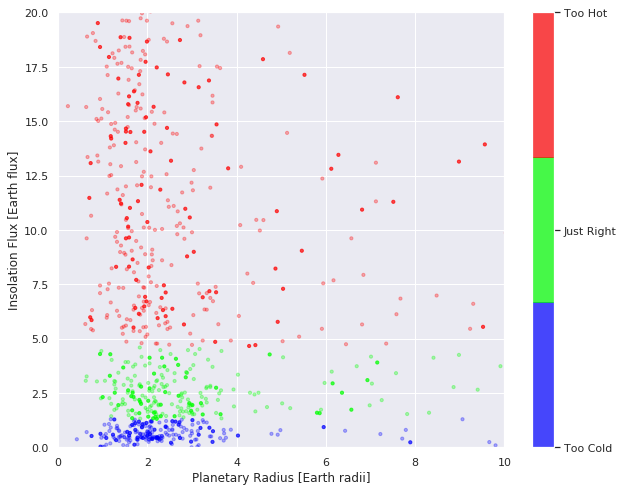

In [80]:
makeNewGraph(dim1, dim3)
plot_svc_decision_function(model);

ValueError: X.shape[1] = 2 should be equal to 3, the number of features at training time

I don't know what that means?